# A/B testing for Cookie Cats mobile game

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. 

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

**Q: how the gate placement affects player retention**


### Outline of the A/B Testing Process

1. Understanding business problem and data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
    - Apply bootstrapping for retention hypothesis testing
    - Check Normality & Homogeneity among groups for rounds played
    - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
5. Evaluate the results
6. Make recommendations

# 1. DATA

The data we have is from 90 189 players that installed the game while the df-test was running. The variables are:

*userid* - a unique number that identifies each player.

*version* - whether the player was put in the control group (*gate_30* - a gate at level 30) or the test group (*gate_40* - a gate at level 40).

*sum_gamerounds* - the number of game rounds played by the player during the first week after installation

*retention_1* - did the player come back and play 1 day after installing?

*retention_7* - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.


In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import opendatasets as od

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
dataset_url='https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing'
od.download(dataset_url)

100%|██████████| 490k/490k [00:00<00:00, 919kB/s] 

In [15]:
df = pd.read_csv("/Users/anastasia/Desktop/projects/AB_testing_mobile_game/data/cookie_cats.csv")

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# 2. SUMMARY STATS

Let's deep dive into dataset. First, let's have an summary stats of the dataset. Second, have a look at how many players we have. Next, try to observe the differences between A/B group in terms of given variables. 

In [16]:
df.describe()

,userid,sum_gamerounds
count,90189.0000,90189.0000
mean,4998412.2345,51.8725
std,2883285.6077,195.0509
min,116.0000,0.0000
25%,2512230.0000,5.0000
50%,4995815.0000,16.0000
75%,7496452.0000,51.0000
max,9999861.0000,49854.0000


In [17]:
# Number of Unique User
df.userid.nunique()

90189

In [18]:
# retention for each A/B group
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.4482,0.1902,2344795
gate_40,45489,0.4423,0.1820,2333530


It looks like there is roughly the same number of players in each group. 

A little less than half of the players come back one day after installing the game. 18% of the players come back 7 day after installing the game. 

Retantion difference:

* There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%). 

* Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%). 

* It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future? 

In [19]:
# game rounds for each A/B group
df.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


In the meantime, there are extreme values in the "sum_gamerounds".

Let's check the distribution of sum_gamerounds variable to get get a better understanding of outliers.

# 3. OUTLIERS

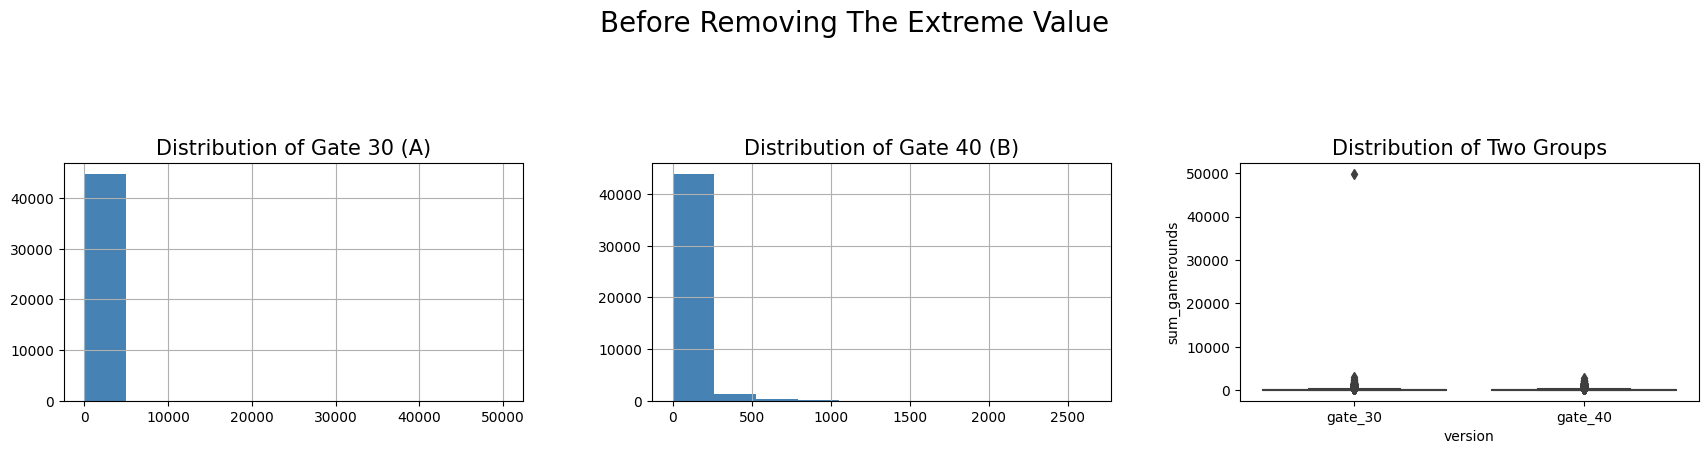

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

In [21]:
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


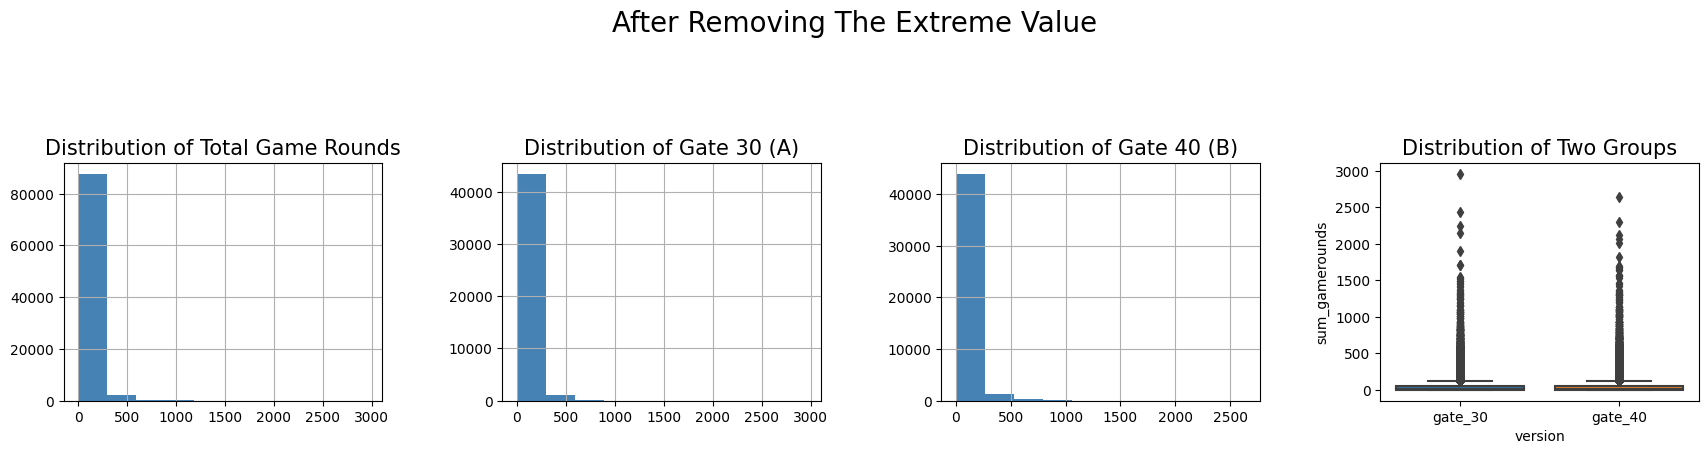

In [22]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
df.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

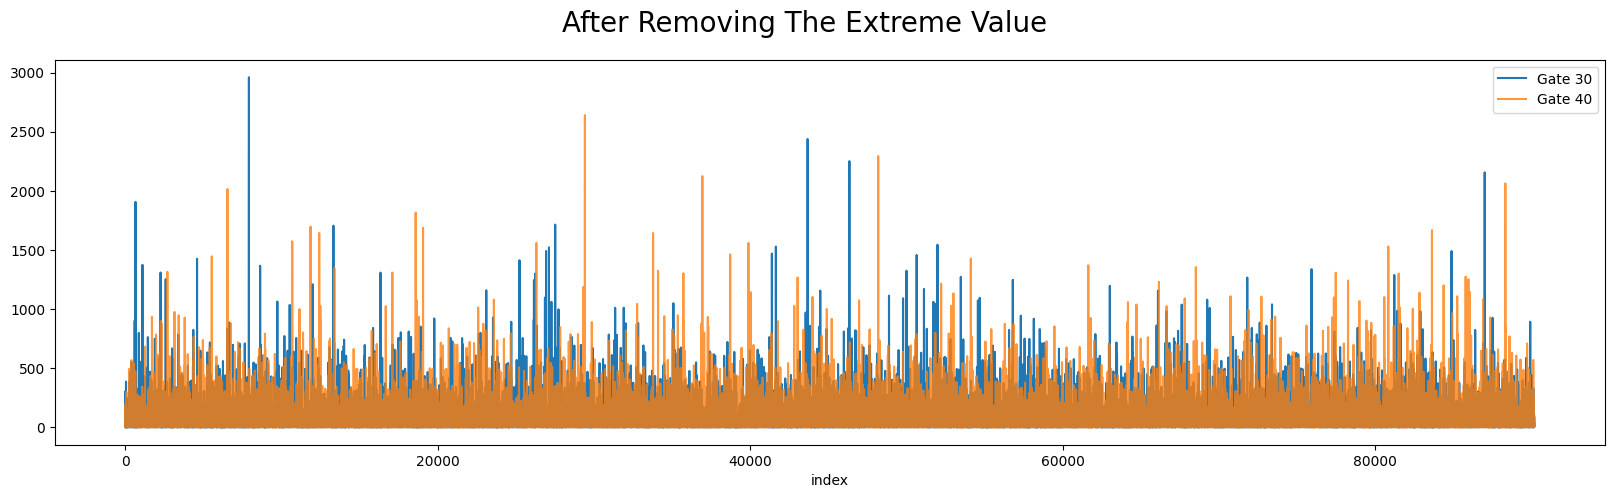

In [23]:
df[(df.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

# 4. A/B Testing
## 4.1 Retention

We'll use **bootstrapping** for A/B testing. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). As the population is unknown, the true error in a sample statistic against its population value is unknown. In bootstrap-resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference of the 'true' sample from resampled data (resampled → sample) is measurable. 

**Testing Steps:**
1. Creating 5000 samples of dataset **(bootstraping)**
2. Calculating 1-day & 7-days retentions for A/B groups
3. Plotting the bootstrap distributions
4. Calculating retention rate difference between the two A/B groups
5. Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
6. Evaluating results and making recommendation

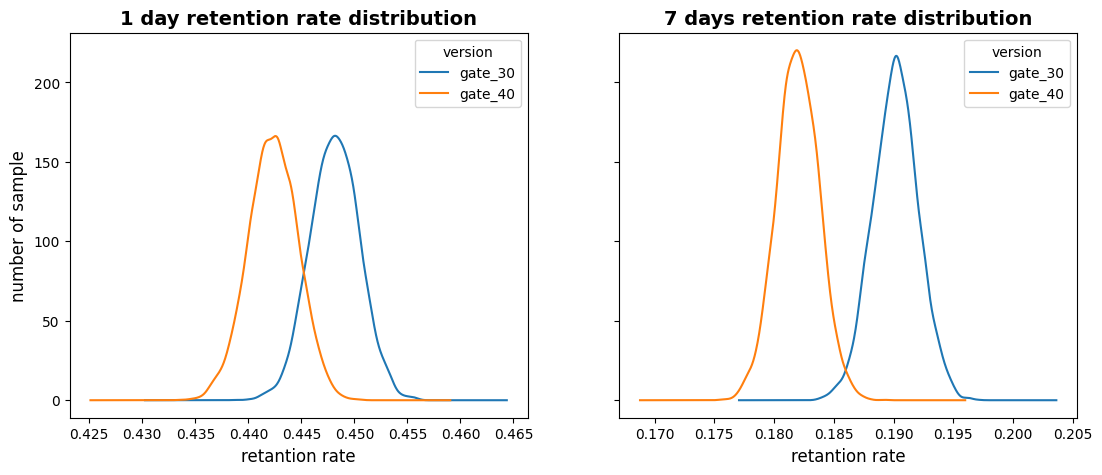

In [24]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(5000):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Kernel Density Estimate plot of the bootstrap distributions
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=axes[0])
axes[0].set_xlabel("retantion rate",size=12)
axes[0].set_ylabel("number of sample",size=12)
axes[0].set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=axes[1])
axes[1].set_xlabel("retantion rate",size=12)
axes[1].set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day & 7-days retention could be for the two A/B groups. We can see that there seems to be some evidence of a difference, but small. Let's zoom in on the differences.

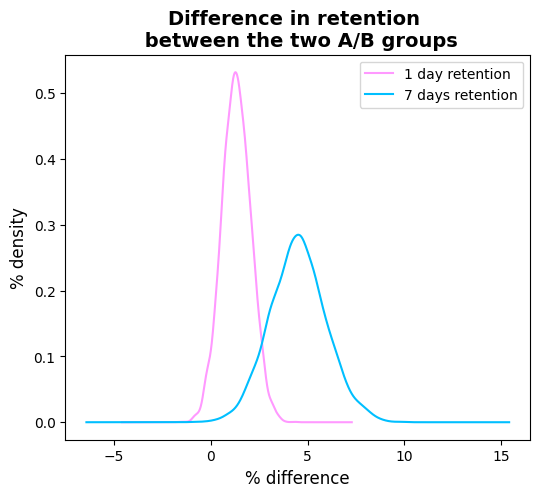

In [25]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, ax = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax, c= "#00bfff", label = "7 days retention")
ax.set_xlabel("% difference",size=12)
ax.set_ylabel("% density",size=12)
ax.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

From these chart, we can see that the most likely % difference is around 1% - 2% for 1-day retention. For 7-days retention the most likely % difference is around 2% - 5%. Moreover, the most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.

In [26]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 96.0%       
The probability that 7-days retention is greater when the gate is at level 30: 99.9% 


The bootstrap result tells us that there is strong evidence **99.9% probability** that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should move the gate from level 30 to level 40. 

Now let's look at the number of game rounds played.

## 4.2 Game rounds played

In [27]:
# A/B Groups & Target Summary Stats
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


Looking at the summary statistics, the control and test groups seem similar, but are the two groups statistically significant? We will investigate this statistically.

In [28]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


**Retention variables gives us player retention details.**

retention_1 - did the player come back and play 1 day after installing?
retention_7- did the player come back and play 7 days after installing?

Also players tend not to play the game! There are many players who quit the game.

- 55 percent of the players didn't play the game 1 day after insalling
- 81 percent of the players didn't play the game 7 day after insalling

In [29]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [30]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.

In [31]:
df["Retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

Similar results are seen when the number of users who came and did not come 1 day and 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.

### Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

### Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [32]:
# Define A/B groups
df["version"] = np.where(df.version == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


In [33]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "df Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["df Hypothesis"] = np.where(temp["df Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["df Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","df Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","df Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,df Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.0509,A/B groups are similar!


# 5. Conclusion

Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots helped us to understand the data and problem.

After applying A/B Testing, the analysis result gives us some important information:

* If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.
* When is comes to game rounds, Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing failed to reject H0 hypothesis and we learned A/B groups are similar in terms of the sum of game rounds played. Hence, there is no statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds. 

# 6. Reccomendations

### Which level has more advantages in terms of player retention?

* 1-day and 7-day average retention slightly higher when the gate is at level 30 than when it is at level 40. 
* There is no difference between groups when it comes to the number of rounds played.

In [34]:
df.groupby("version").retention_1.mean(), df.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

The gate should be at level 30 but average retentions look like similar. We need more data for similarity.